# 1. Load Dataset

In [1]:
!mkdir data
%cd data

!gdown 1vSevps_hV5zhVf6aWuN8X7dd-qSAIgcc

%cd ..

d:\AIVietNam\2024\aio-2024-hw\module-6\21_12_2024_M06W04\data
d:\AIVietNam\2024\aio-2024-hw\module-6\21_12_2024_M06W04


Downloading...
From (original): https://drive.google.com/uc?id=1vSevps_hV5zhVf6aWuN8X7dd-qSAIgcc
From (redirected): https://drive.google.com/uc?id=1vSevps_hV5zhVf6aWuN8X7dd-qSAIgcc&confirm=t&uuid=83b96fb4-26f6-4d94-a235-5329e8716943
To: d:\AIVietNam\2024\aio-2024-hw\module-6\21_12_2024_M06W04\data\flower_photos.zip

  0%|          | 0.00/230M [00:00<?, ?B/s]
  0%|          | 524k/230M [00:00<03:27, 1.10MB/s]
  0%|          | 1.05M/230M [00:00<02:00, 1.90MB/s]
  1%|          | 1.57M/230M [00:00<01:28, 2.58MB/s]
  1%|          | 2.10M/230M [00:00<01:11, 3.18MB/s]
  1%|▏         | 3.15M/230M [00:00<00:50, 4.52MB/s]
  2%|▏         | 4.72M/230M [00:01<00:31, 7.20MB/s]
  3%|▎         | 6.29M/230M [00:01<00:34, 6.49MB/s]
  4%|▍         | 9.44M/230M [00:01<00:19, 11.3MB/s]
  6%|▌         | 13.6M/230M [00:01<00:13, 16.0MB/s]
  8%|▊         | 17.3M/230M [00:01<00:10, 20.0MB/s]
  9%|▉         | 20.4M/230M [00:01<00:09, 22.1MB/s]
 10%|█         | 23.1M/230M [00:02<00:10, 19.3MB/s]
 11%|█         |

In [2]:
import zipfile

with zipfile.ZipFile('./data/flower_photos.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')

In [3]:
import os
import math
import torch
import torchvision.transforms as transforms
import torch.optim as optim

from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch import nn

In [4]:
data_patch = './data/flower_photos'
dataset = ImageFolder(root=data_patch)
num_samples = len(dataset)
classes = dataset.classes
num_classes = len(classes)

TRAIN_RATIO, VALID_RATIO = 0.8, 0.1
n_train_examples = int(num_samples * TRAIN_RATIO)
n_valid_examples = int(num_samples * VALID_RATIO)
n_test_examples = num_samples - n_train_examples - n_valid_examples

train_dataset, valid_dataset, test_dataset = random_split(dataset, [n_train_examples, n_valid_examples, n_test_examples])

train_dataset


# 2. Preprocessing

In [5]:
IMG_SIZE = 224

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

train_dataset.dataset.transform = train_transforms
valid_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms


# 3. DataLoader

In [6]:
BATCH_SIZE = 512

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 4. Training from Scratch

## 4.1. Modeling

In [8]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True),
        )
        self.norm1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.norm2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value):
        attn_output, _ = self.attn(query, key, value)
        attn_output = self.dropout(attn_output)
        out1 = self.norm1(query + attn_output)
        ffn_output = self.ffn(out1)
        out2 = self.norm2(out1 + ffn_output)
        return out2
    
class PatchPositionEmbedding(nn.Module):
    def __init__(self, image_size=224, embed_dim=512, patch_size=16, device='cpu'):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
            bias=False,
        )
        scale = embed_dim ** -0.5
        self.positional_embedding = nn.Parameter(
            scale * torch.randn((image_size // patch_size) ** 2, embed_dim)
        )
        self.device = device

    def forward(self, x):
        x = self.conv1(x) # shape = [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1) # shape = [*, width, grid * grid]
        x = x.permute(0, 2, 1) # shape = [*, grid * grid, width]
        x = x + self.positional_embedding.to(self.device)
        return x
    
class VisionTransformerCls(nn.Module):
    def __init__(
        self,
        image_size,
        embed_dim,
        num_heads,
        ff_dim,
        dropout=0.1,
        num_classes=10,
        patch_size=16,
        device='cpu',
    ):
        super().__init__()
        self.patch_embedding = PatchPositionEmbedding(
            image_size=image_size,
            embed_dim=embed_dim,
            patch_size=patch_size,
            device=device,
        )
        self.transformer = TransformerEncoder(
            embed_dim=embed_dim,
            num_heads=num_heads,
            ff_dim=ff_dim,
            dropout=dropout,
        )
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=num_classes)
        self.dropout = nn.Dropout(p=dropout)
        self.device = device

    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.transformer(x, x, x)
        x = x[:, 0, :]
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## 4.2 Training

In [9]:
import os
import time


def train_epoch(model, optimizer, criterion, train_loader, device, epoch=0, log_interval=50):
    model.train()
    total_acc = total_cnt = 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        predictions = model(inputs)

        loss = criterion(predictions, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(dim=1) == labels).sum().item()
        total_cnt += labels.size(0)

        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(f"Epoch {epoch} | {idx}/{len(train_loader)} batches | "
                  f"loss={loss.item():.4f} | acc={total_acc/total_cnt:.4f} | "
                  f"{elapsed}s/batch")
            start_time = time.time()
            total_acc = total_cnt = 0
            start_time = time.time()

    epoch_acc = total_acc / total_cnt
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss


def evaluate_epoch(model, criterion, valid_loader, device):
    model.eval()
    total_acc = total_cnt = 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)
            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(dim=1) == labels).sum().item()
            total_cnt += labels.size(0)

    epoch_acc = total_acc / total_cnt
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss


def train(model, model_name, save_model, optimizer, criterion, train_loader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = float('inf')
    times = []

    save_path = os.path.join(save_model, f"{model_name}_best.pth")

    for epoch in range(1, num_epochs + 1):
        start_time = time.time()
        train_acc, train_loss = train_epoch(
            model, optimizer, criterion, train_loader, device, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        eval_acc, eval_loss = evaluate_epoch(
            model, criterion, valid_dataloader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        if eval_loss < best_loss_eval:
            best_loss_eval = eval_loss
            torch.save(model.state_dict(), save_path)

        elapsed = time.time() - start_time
        times.append(elapsed)

        print('-' * 100)
        print(f"Epoch {epoch} | Train Acc: {train_acc:.4f} | Train Loss: {train_loss:.4f} | "
              f"Eval Acc: {eval_acc:.4f} | Eval Loss: {eval_loss:.4f} | "
              f"{elapsed}s")
        print('-' * 100)

    model.load_state_dict(torch.load(save_path))
    model.eval()
    metrics = {
        'train_accs': train_accs,
        'train_losses': train_losses,
        'eval_accs': eval_accs,
        'eval_losses': eval_losses,
        'times': times
    }
    return model, metrics

In [13]:
import matplotlib.pyplot as plt


def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(1, num_epochs + 1))  # Start from 1
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    # Plot accuracy
    axs[0].plot(epochs, train_accs, label='Train Acc')
    axs[0].plot(epochs, eval_accs, label='Eval Acc')
    axs[0].set_title('Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    # Plot loss
    axs[1].plot(epochs, train_losses, label='Train Loss')
    axs[1].plot(epochs, eval_losses, label='Eval Loss')
    axs[1].set_title('Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

In [11]:
image_size = 224
embed_dim = 512
num_heads = 4
patch_size = 16
ff_dim = 128
dropout = 0.1

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = VisionTransformerCls(
    image_size=image_size,
    embed_dim=embed_dim,
    num_heads=num_heads,
    ff_dim=ff_dim,
    dropout=dropout,
    num_classes=num_classes,
    patch_size=patch_size,
    device=device,
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

n_epochs = 10

save_model = './models'
os.makedirs(save_model, exist_ok=True)
model_name = 'vit_flowers'

model, metrics = train(
    model,
    model_name,
    save_model,
    optimizer,
    criterion,
    train_loader,
    valid_loader,
    n_epochs,
    device,
)


----------------------------------------------------------------------------------------------------
Epoch 1 | Train Acc: 0.2660 | Train Loss: 1.5896 | Eval Acc: 0.3161 | Eval Loss: 1.5161 | 430.9377164840698s
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch 2 | Train Acc: 0.3392 | Train Loss: 1.4781 | Eval Acc: 0.3324 | Eval Loss: 1.4665 | 302.39617252349854s
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch 3 | Train Acc: 0.3828 | Train Loss: 1.4124 | Eval Acc: 0.3842 | Eval Loss: 1.4266 | 299.0432014465332s
----------------------------------------------------------------------------------------------------
------------------------------------------------------------------

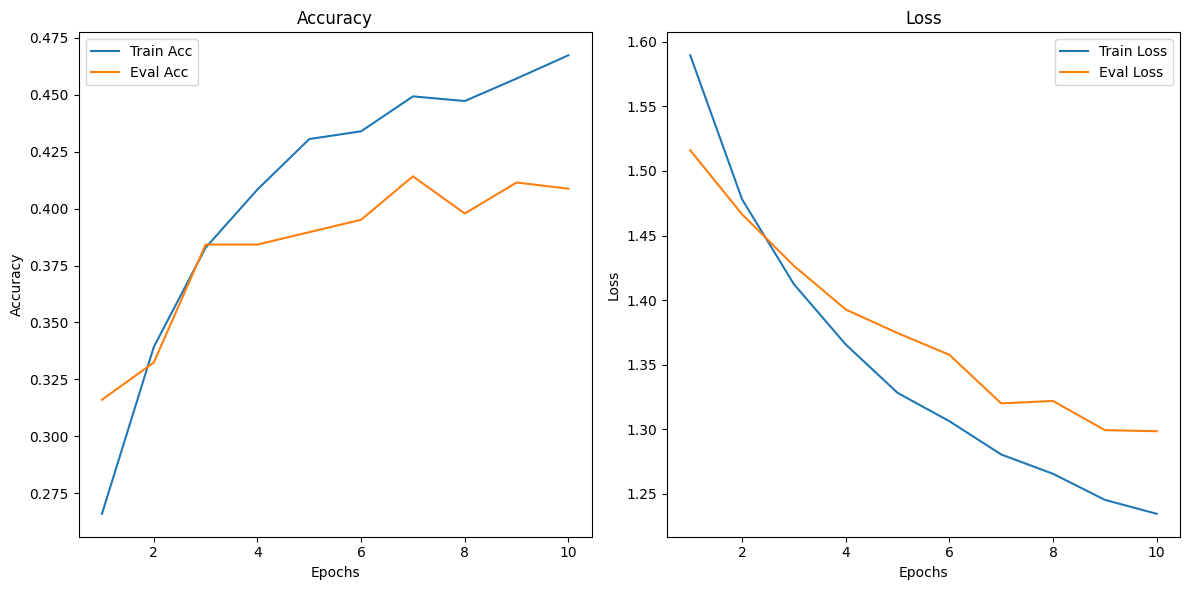

In [14]:
plot_result(n_epochs, metrics['train_accs'], metrics['eval_accs'], metrics['train_losses'], metrics['eval_losses'])

# 5. Fine Tuning

## 5.1 Modeling

In [15]:
from transformers import ViTForImageClassification

id2label = {id:label for id, label in enumerate(classes)}
label2id = {label:id for id, label in enumerate(classes)}

model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=num_classes,
    id2label=id2label,
    label2id=label2id,
)

model.to(device)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

c:\Users\Admin\anaconda3\envs\aio2024-hw\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub\models--google--vit-base-patch16-224-in21k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

## 5.2 Metric

In [16]:
import evaluate
import numpy as np

metrics = evaluate.load('accuracy')

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis = 1)
    return metrics.compute(predictions = preds, references = p.labels)




## 5.3 Trainer

In [23]:
import torch
from transformers import ViTImageProcessor
from transformers import TrainingArguments, Trainer

# Load pretrained ViT image processor
feature_extractor = ViTImageProcessor.from_pretrained(
    "google/vit-base-patch16-224-in21k"
)

metric_name = "accuracy"

# Define training arguments
args = TrainingArguments(
    f"models",  # output directory
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=512,
    per_device_eval_batch_size=512,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)


def collate_fn(examples):
    """
    Collate function to prepare batch data
    Args:
        examples: List of tuples (image, label)
    Returns:
        dict: Contains batched pixel_values and labels
    """
    pixel_values = torch.stack([example[0] for example in examples])
    labels = torch.tensor([example[1] for example in examples])
    return {
        "pixel_values": pixel_values,
        "labels": labels
    }


# Initialize trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_17956\3875719394.py:46: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## 5.4 Training

In [24]:
trainer.train()
outputs = trainer.predict(test_dataset)
outputs.metrics


: 